In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0-dev20190323


## Regression: ABD1_40h predicting SUM_AVGR

**Import it using pandas**

In [2]:
abd = pd.read_csv('ABD1_40h.stats', sep='\t')
FEATURES = ['SUM_AVGR','ALL_ACK5W','ALL_ACK10W','ALL_ACK15W','ALL_ACK20W','ALL_ACK25W',
            'S2D','S2S','ARI','CLI','DC','DWCP','FLESH','FRES','TTR','VL','ZR2',
            'L_ABD1_DDXFINWORTHO_AVG_DOWN_MAXCOS','L_ABD1_DDXFINWORTHO_AVG_DOWN_RATING',
            'L_ABD1_DDXFINWORTHO_AVG_DOWN_WEIGHTED','L_ABD1_DDXFINWORTHO_AVG_UP_MAXCOS',
            'L_ABD1_DDXFINWORTHO_AVG_UP_RATING','L_ABD1_DDXFINWORTHO_AVG_UP_WEIGHTED',
            'L_ABD1_ANCHOR_MAXCOS','L_ABD1_ANCHOR_RATING','L_ABD1_ANCHOR_WEIGHTED',
            'COS_BP_Combined','COS_BP_Management','COS_BP_Summary','ENTROPY_UTD','PERPLEXITY_UTD']

FEATURES = ['SUM_AVGR', 'CLI', 'DC', 'TTR', 'ZR2', 'L_ABD1_DDXFINWORTHO_AVG_DOWN_RATING', 'L_ABD1_DDXFINWORTHO_AVG_UP_MAXCOS']
LABEL = 'SUM_AVGR'
dataset = abd[0:][FEATURES]
dataset.tail()

,SUM_AVGR,CLI,DC,TTR,ZR2,L_ABD1_DDXFINWORTHO_AVG_DOWN_RATING,L_ABD1_DDXFINWORTHO_AVG_UP_MAXCOS
139,9.5,15.510253,0.521839,0.491954,0.292069,2,0.869101
140,11.0,9.725808,0.658487,0.482618,0.313941,2,0.906987
141,9.0,9.789449,0.588406,0.547826,0.254099,1,0.889335
142,7.5,11.072603,0.554795,0.510274,0.403151,3,0.824838
143,13.0,13.854920,0.569794,0.528604,0.297578,2,0.916419


**Check the data for NA**<br>

In [3]:
dataset.isna().sum()

SUM_AVGR                               0
CLI                                    0
DC                                     0
TTR                                    0
ZR2                                    0
L_ABD1_DDXFINWORTHO_AVG_DOWN_RATING    0
L_ABD1_DDXFINWORTHO_AVG_UP_MAXCOS      0
dtype: int64

In [4]:
#dataset = dataset.dropna()

**Split the data into train and test**<br>
Now split the dataset into a training set and a test set.<br>
We will use the test set in the final evaluation of our model.

In [5]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

**Inspect the data**<br>
Have a quick look at the joint distribution of a few pairs of columns from the training set.

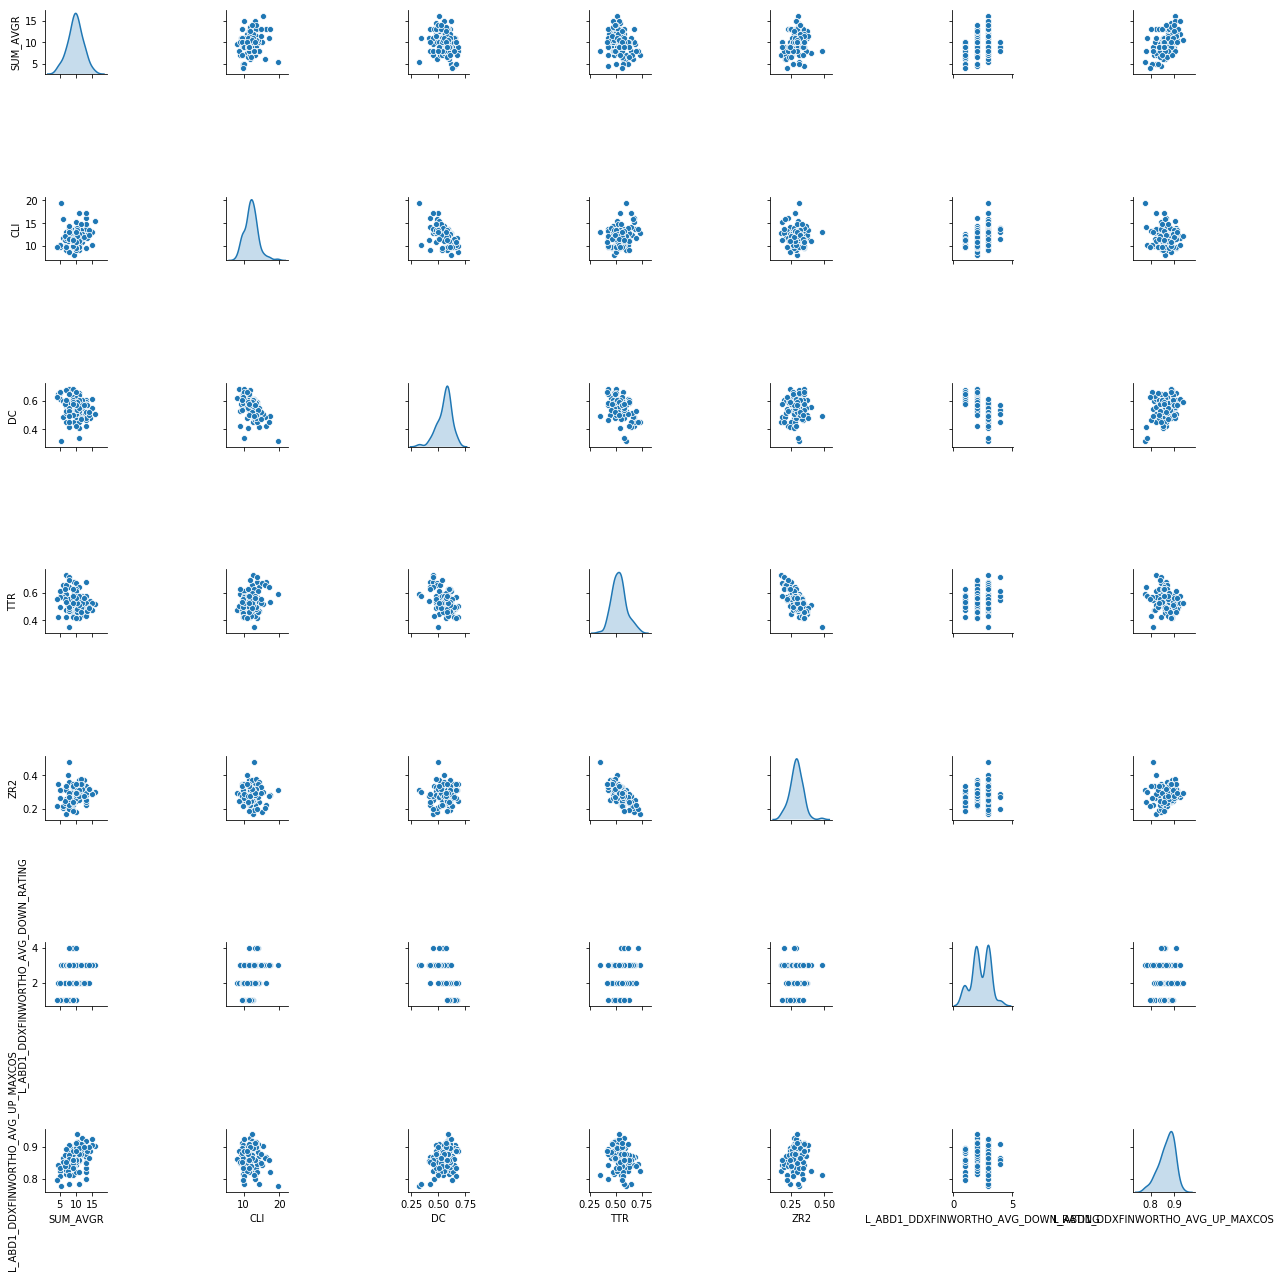

In [6]:
sns.pairplot(train_dataset[FEATURES], diag_kind="kde")

In [7]:
train_stats = train_dataset.describe()
train_stats.pop("SUM_AVGR")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
CLI,115.0,12.209349,1.869420,8.123704,11.206011,12.184505,13.160880,19.541166
DC,115.0,0.558946,0.067188,0.318386,0.524040,0.573944,0.601421,0.685629
TTR,115.0,0.534414,0.069126,0.350120,0.486632,0.530675,0.571537,0.729412
ZR2,115.0,0.291129,0.048045,0.171668,0.264081,0.293615,0.316937,0.481956
L_ABD1_DDXFINWORTHO_AVG_DOWN_RATING,115.0,2.347826,0.761387,1.000000,2.000000,2.000000,3.000000,4.000000
L_ABD1_DDXFINWORTHO_AVG_UP_MAXCOS,115.0,0.869857,0.033657,0.775270,0.850378,0.876218,0.894316,0.938742


In [8]:
train_labels = train_dataset.pop('SUM_AVGR')
test_labels = test_dataset.pop('SUM_AVGR')

**Normalize the data**

Look again at the train_stats block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [9]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier. That includes the test set as well as live data when the model is used in production.

## The Model

**Build the model**

Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value.

The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [10]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [11]:
model = build_model()

**Inspect the model**<br>
Use the .summary method to print a simple description of the model

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [13]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.21058577],
       [-0.09741803],
       [-0.28318483],
       [-0.14613506],
       [-0.06998242],
       [-0.42081052],
       [-0.18925533],
       [-0.23878883],
       [ 0.02920975],
       [-0.57653993]], dtype=float32)

In [14]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualize the model's training progress using the stats stored in the history object.

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.156063,0.323141,0.156063,4.151290,1.689616,4.151290,995
996,0.049533,0.139576,0.049533,4.219321,1.732441,4.219321,996
997,0.034530,0.100748,0.034530,4.237202,1.715032,4.237202,997
998,0.034584,0.103646,0.034584,4.198279,1.731314,4.198279,998
999,0.035238,0.109328,0.035238,4.131804,1.696131,4.131804,999


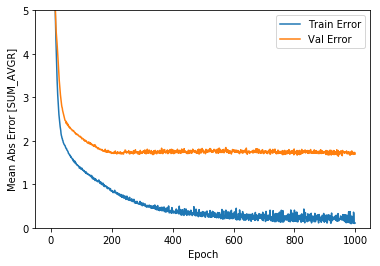

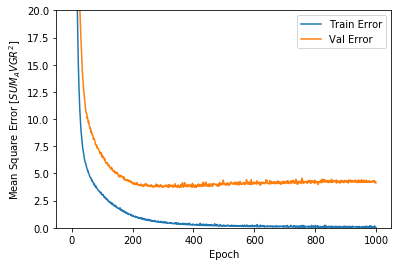

In [16]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [SUM_AVGR]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$SUM_AVGR^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph shows little improvement, or even degradation in the validation error after about 300 epochs. Let's update the model.fit call to automatically stop training when the validation score doesn't improve. We'll use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.
You can learn more about this callback [here.](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)


....................................................................................................
....................................................................................................
.............................................................................

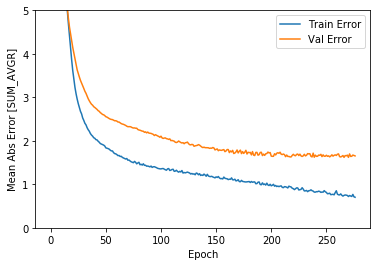

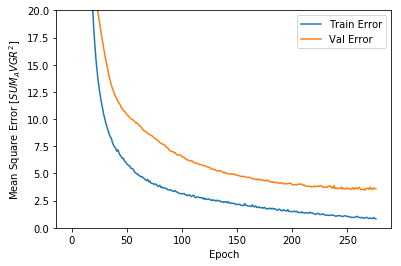

In [17]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 2 SUM_AVGR.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world.

In [18]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} SUM_AVGR".format(mae))

Testing set Mean Abs Error:  1.48 SUM_AVGR


**Make predictions**

Finally, predict SUM_AVGR values using data in the testing set:

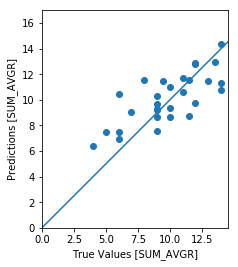

In [19]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [SUM_AVGR]')
plt.ylabel('Predictions [SUM_AVGR]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])



It looks like our model predicts reasonably well. Let's take a look at the error distribution.

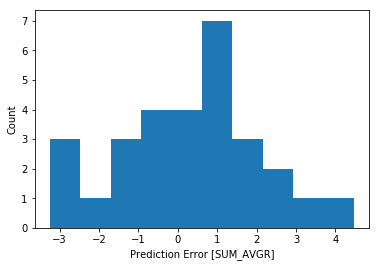

In [20]:
error = test_predictions - test_labels
plt.hist(error)
plt.xlabel("Prediction Error [SUM_AVGR]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.



## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.